In [2]:
import numpy as np
from numpy import pi, cos, arccos, sin
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
SUN_PATH = pd.DataFrame(np.array([[80, 172, 264, 355], [0, pi/2, pi, -pi/2], [0, np.radians(23.5), 0, np.radians(-23.5)]]).transpose(), columns=['Day of year', 'Ra', 'Dec'])

SUN_PATH

,Day of year,Ra,Dec
0,80.0,0.000000,0.000000
1,172.0,1.570796,0.410152
2,264.0,3.141593,0.000000
3,355.0,-1.570796,-0.410152


In [51]:
df = pd.read_csv("Ariel_MCS_TPCs_01May2023.csv")

starRA = np.radians(df['Star RA'])
starRA = starRA.apply(lambda x: x-2*pi if x>pi else x)
starDEC = np.radians(df['Star Dec'])

Equation for angular distance between two points on the celestial sphere is given by:

$$ \theta =  cos^{-1}[sin(\delta_1)sin(\delta_2) + cos(\delta_1)cos(\delta_2)cos(\alpha_2 - \alpha_1)] $$

In [52]:
MIN_ANGLE_TOWARDS_SUN = 70 # in degrees
MIN_ANGLE_AWAY_SUN = 60 # in degrees
NUM_LON_PTS = 50 # number of longitudinal points for background and sinusoid (more points => smoother look)
NUM_LAT_PTS = NUM_LON_PTS//2 # number of latiitudinal points for background (more points => smoother look)


# def correct_Ra(x):
#     if type(x) == float:
#         if x > pi:
#             return x - 2*pi
#         else:
#             return x
#     elif type(x) == np.ndarray:
#         updated = np.where(x>pi, x-2*pi, x)
#         return updated

def dist_angle(dec1,ra1, dec2,ra2):
    distance = arccos( sin(dec1)*sin(dec2) + cos(dec1)*cos(dec2)*cos(ra2-ra1) )
    
    # adj_lon = abs(min(ra1,ra2)+2*pi - max(ra1,ra2))
    # adj_lat = abs(min(dec1,dec2)+pi/2 - max(dec1,dec2))
    
    # dlon = min(abs(ra2-ra1), adj_lon)
    # dlat = min(abs(dec2-dec1), adj_lat)
    
    # distance = np.sqrt(dlon**2 + dlat**2)
    return distance

def ecliptic(x):
    return SUN_PATH['Dec'][1]*np.sin(x)


ra = np.linspace(-pi, pi, NUM_LON_PTS)
dec = np.linspace(-pi/2, pi/2, NUM_LAT_PTS)
ecl = ecliptic(ra)

# background plot
Lon, Lat = np.meshgrid(ra, dec)    

rho = np.zeros(np.shape(Lon))
for n in range(len(ra)):
    for i, row in enumerate(dec):
        for j, col in enumerate(ra):
            if dist_angle(row,col, ecl[n],ra[n]) > np.radians(MIN_ANGLE_TOWARDS_SUN) and dist_angle(row, col, ecl[n]+pi, ra[n]) > np.radians(MIN_ANGLE_AWAY_SUN):
                rho[i][j] += 1
rho /= NUM_LON_PTS

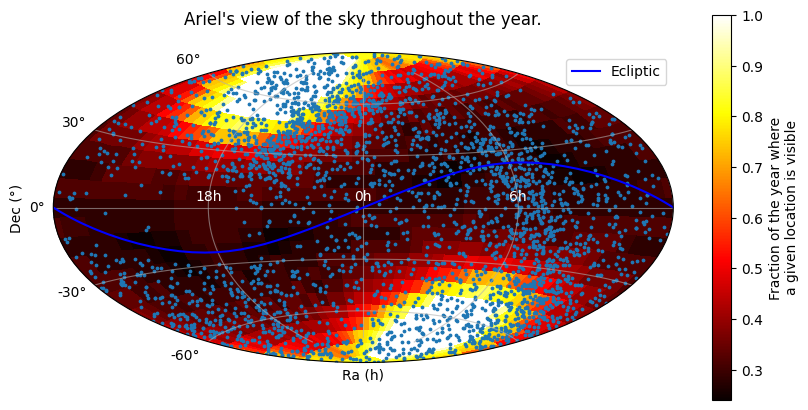

In [60]:
plt.figure(figsize=(10,5))
plt.subplot(projection = 'aitoff')
plt.grid(True, alpha=.6)

plt.pcolormesh(Lon, Lat, rho, cmap='hot')
plt.colorbar(label="Fraction of the year where\na given location is visible")

# plt.scatter(SUN_PATH['Ra'], SUN_PATH['Dec'], color='green', marker='o', s=15) # plots the position of the sun for key dates.
plt.plot(ra, ecl, label='Ecliptic', color='blue') # plotting ecliptic
plt.scatter(starRA, starDEC, s=3)

plt.xticks([-pi/2, 0, pi/2], ['18h', '0h', '6h'], color='white')
plt.yticks([-pi/3, -pi/6, 0, pi/6, pi/3])

plt.xlabel('Ra (h)')
plt.ylabel('Dec (\u00B0)')
plt.legend(loc='best')


plt.title(f"Ariel's view of the sky throughout the year.", pad=20)
plt.savefig(f"Visibility Plots/VisibilityPlot.png", bbox_inches='tight', dpi=300)
plt.show()